# Qubit Two Tone Frequency and Power Sweep

This experiment run a sweep in both Qubit Power and Qubit Frequency. The VNA is used to track the changes at the read-out resonator and needs to be set at the frequency corresponding to the flux value used for the measurement.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects  as go 

from IPython.display import clear_output
from time import sleep
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *


In [7]:
lo = SGS100A_driver('TCPIP0::192.168.0.36::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()
lo.open()
f_c = 0    # Initial Frequency 

twpa_on = False
if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.36::inst0::INSTR')
    twpa.open()
else:
    twpa = SGS100A_driver('dummy')

meas = 'S21'

Could not connect to dummy


In [10]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'twotone_f_pow_psweep'


# Qubit Parameters
params['qubit_name'] = '2qcrc7bq2'
params['qubit_power'] = -12
params['twpa_power'] = 0.0
params['twpa_frequency'] = 0.0
params['twpa_on'] = False
params['vna_power'] = -60 #Single Photon Regime
params['center_freq'] = 6962970000.00
params['span_freq'] = 20
params['flux_curr'] = 0
params['temp'] = 25.7
params['comment'] = "# 2qcrc7bq2\n" +\
                    "# " +\
                    "# " +\
                    "# \n"

params['qubitFreqInitial'] = 5600
params['qubitFreqFinal'] = 6100
params['qubitFreqStep'] = 2

params['qubit_power_initial'] = 0
params['qubit_power_final'] = -12
params['qubit_power_step'] = -1

if params['twpa_on']:
    twpa.setup(params['twpa_frequency'], params['twpa_power'])

qubitFreq_array = np.arange(params['qubitFreqInitial'],params['qubitFreqFinal'],params['qubitFreqStep'])
lopower_array = np.arange(params['qubit_power_initial'],params['qubit_power_final'],params['qubit_power_step'])


# Check that the f of the resonator is correct 
#f_c=0
if f_c == 0:
    with twpa:
        freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
    f_c, Qf, fwhm = Q(freqs,mag, True)
    print('Center frequency: %2.2f Hz'%f_c)
    print('FWHM: %2.2f kHz'%(fwhm*1e-3))
    print('Quality Factor: %2.2f'%Qf)

#Initialize the VNA for the 2tone measurement
with twpa:
    freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3, meas = meas)

maxv = np.mean(mag)
delay = 1.0

#Initialize the Local Oscillator
lo.open()
lo.set_level(min(lopower_array)) # dBm
lo.close()
tt = (delay+1)*(len(lopower_array)*len(qubitFreq_array))/60.0
print('Estimated time for test = %2.2f min'%tt)

vna.start_rf()

Estimated time for test = 100.00 min


In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as go 


#Initialize variables for storage
mags = np.ndarray((len(qubitFreq_array),len(lopower_array)))
phases = np.ndarray((len(qubitFreq_array),len(lopower_array)))

mags[:] =maxv
phases[:] = 0

try:
    for idx_power, lo_power in enumerate(lopower_array): 

        with twpa:
            #Update center frequecy of the resonator
            freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
            f_c, Qf, fwhm = Q(freqs,mag, False)
            
            print('Center frequency: %2.2f Hz'%f_c)
            print('FWHM: %2.2f kHz'%(fwhm*1e-3))
            print('Quality Factor: %2.2f'%Qf)

            freqs, mag, phase = meas_spectrum(vna, 
                       f_c = f_c, 
                       f_span= 10e-6, # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 3, 
                       sleep_t = 3, meas = meas)
            phase0 = np.mean(phase)
        
        with(lo):
            lo.set_level(lo_power)

        sleep(0.1)
        for idx,qfreq in enumerate(qubitFreq_array):
            with lo:
                lo.set_RF(qfreq)
                with twpa:   
                    sleep(0.2)
                    clear_output(wait=True)
                    vna.reset_average()
                    sleep(delay)
                    mag, phase =  vna.get_data( meas = meas)
                    mags[idx,idx_power] = mag[1]
                    phases[idx,idx_power] = phase[1]-phase0

            # Plot
            fig = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
            fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=mags, colorbar=dict(x=.45,len=1)))
            fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
            fig.show()
            
            #plt.pcolor(lopower_array,qubitFreq_array,mags)
            #plt.show()
    Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    print('Measurement finished. Stopping the sources.')
    vna.stop_rf()


filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
header_str = get_plot_str(params, filename)
np.savez("./data/"+filename,
         header = header_str,
         freqs=qubitFreq_array,
         axis2 = lopower_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

Measurement finished. Stopping the sources.
file saved as twotone_f_pow_psweep_2qcrc7bq2_20240618_1339


In [3]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as go 
 
fig = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=mags, colorbar=dict(x=.45,len=1)))
fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
fig.show()

NameError: name 'lopower_array' is not defined

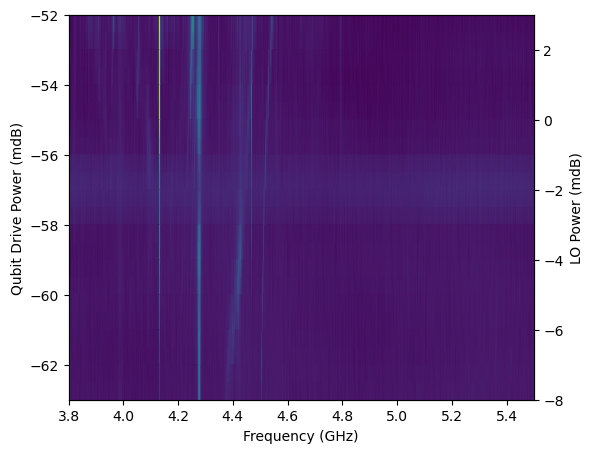

In [42]:
att = 55
# plt.pcolormesh(qubitFreq_array,lopower_array[:]-att,np.transpose(mags[:,:]), 
#                cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
# plt.show()
# att = 55

fig, ax1 = plt.subplots()
fig.set_size_inches(6,5)

ax1.pcolormesh(qubitFreq_array*1e-3,lopower_array[:]-att,(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('Qubit Drive Power (mdB)')
plt.xlabel('Frequency (GHz)')

ax2 = ax1.twinx()
ax2.pcolormesh(qubitFreq_array*1e-3,lopower_array[:],(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('LO Power (mdB)')
plt.xlabel('Frequency (GHz)')
plt.show()

In [40]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'RK-TWPA_LO_pow_psweep'


# Qubit Parameters
params['qubit_name'] = '5.05mA'
params['qubit_power'] = 0
params['twpa_power'] = 0.0
params['twpa_frequency'] = 5.2
params['twpa_on'] = False
params['vna_power'] = -50 #Single Photon Regime
params['center_freq'] = 7.4e9
params['f_span'] = 1100
params['flux_curr'] = 0
params['temp'] = 25.7
params['comment'] = "# 2qcrc7bq2\n" +\
                    "# " +\
                    "# " +\
                    "# \n"

params['qubitFreqInitial'] = 5400
params['qubitFreqFinal'] = 5900
params['qubitFreqStep'] = 20



params['qubit_power_initial'] = -5
params['qubit_power_final'] = 0
params['qubit_power_step'] = 0.1

if params['twpa_on']:
    twpa.setup(params['twpa_frequency'], params['twpa_power'])

qubitFreq_array = np.arange(params['qubitFreqInitial'],params['qubitFreqFinal'],params['qubitFreqStep'])
lopower_array = np.arange(params['qubit_power_initial'],params['qubit_power_final'],params['qubit_power_step'])


# Check that the f of the resonator is correct 
#f_c=0
# if f_c == 0:
#     with twpa:
#         freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
#     f_c, Qf, fwhm = Q(freqs,mag, True)
#     print('Center frequency: %2.2f Hz'%f_c)
#     print('FWHM: %2.2f kHz'%(fwhm*1e-3))
#     print('Quality Factor: %2.2f'%Qf)

#Initialize the VNA for the 2tone measurement
with twpa:
    freqs, mag, phase = meas_spectrum(vna, 
                       f_c = params['center_freq'], 
                       f_span= params['f_span'], # VNA in unit MHz
                       power = params['vna_power'],
                       npoints = 1000, 
                       sleep_t = 10, meas = meas)

# maxv = np.mean(mag)
delay = 1.0

#Initialize the Local Oscillator
lo.open()
lo.set_level(min(lopower_array)) # dBm
lo.close()
tt = (delay+1)*(len(lopower_array)*len(qubitFreq_array))/60.0
print('Estimated time for test = %2.2f min'%tt)

vna.start_rf()

Estimated time for test = 41.67 min


In [35]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as go 


#Initialize variables for storage
npoints=1000
mags = np.ndarray((len(lopower_array), npoints))
phases = np.ndarray((len(qubitFreq_array),len(lopower_array)))
vna.start_rf()
vna.set_power(params['vna_power'],overule_power=True)

mags[:] = 0
phases[:] = 0
fig_pwr_pump=go.Figure(data=go.Heatmap(z=mags.T, x=lopower_array, y=freqs*1e-6, colorscale='Viridis', zsmooth='fast')) #zmax=20,  zmin=0, zmax=10,  zmin=0

lo.open()
lo.stop_rf()
#lo.set_RF(params['qubitFreqInitial'])
#with twpa:   
clear_output(wait=True)
vna.reset_average()
#delay = max(delays[idx], 0.3)
sleep(1)
mag, phase =  vna.get_data(meas = meas) #freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['f_span'], power = -50, sleep_t = 0.5, npoints = 1001, data_format = 'MA',meas = meas)
mags_pump0 = mag
lo.close()

try:
    for idx, lo_power in enumerate(lopower_array): 

        #with twpa:
            # #Update center frequecy of the resonator
            # freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
            # f_c, Qf, fwhm = Q(freqs,mag, False)
            
            # print('Center frequency: %2.2f Hz'%f_c)
            # print('FWHM: %2.2f kHz'%(fwhm*1e-3))
            # print('Quality Factor: %2.2f'%Qf)

            # freqs, mag, phase = meas_spectrum(vna, 
            #            f_c = f_c, 
            #            f_span= 10e-6, # VNA in unit MHz
            #            power = params['vna_power'],
            #            npoints = 3, 
            #            sleep_t = 3, meas = meas)
            # phase0 = np.mean(phase)
        

        with(lo):
            lo.set_level(lo_power)
            lo.set_RF(5700) #lo.set_RF(params['qubitFreqInitial'])
            #with twpa:   
            #sleep(2)
            clear_output(wait=True)
            vna.reset_average()
            #delay = max(delays[idx], 0.3)
            sleep(5)
            mag, phase =  vna.get_data(meas = meas) #freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['f_span'], power = -50, sleep_t = 0.5, npoints = 1001, data_format = 'MA',meas = meas)
            mags[idx] = mag#/mags_pump0

        
            # Plot
                #fig = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
                #fig.add_trace(go.Heatmap(x=lopower_array,y=freqs*1e-6, z=mags.T, colorbar=dict(x=.45,len=1)))
            #fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
                #fig.show()
            fig_pwr_pump.data[0].z=mags.T
            fig_pwr_pump.show()
            
            #plt.pcolor(lopower_array,qubitFreq_array,mags)
            #plt.show()
    #Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    print('Measurement finished. Stopping the sources.')
    vna.stop_rf()


# filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
# header_str = get_plot_str(params, filename)
# np.savez("./data/"+filename,
#          header = header_str,
#          freqs=qubitFreq_array,
#          axis2 = lopower_array,
#          mags=mags,
#          phases=phases)
# print('file saved as %s'%filename)

Stopped
Measurement finished. Stopping the sources.


In [36]:
fig_p_pump_=go.Figure(data=go.Heatmap(z=np.transpose(20*np.log10(mags.T)),
                                    y=lopower_array,
                                    x=freqs*1e-6,
                                    colorscale='Viridis',
                                    #zmax=30,
                                    zmax=20*np.log10(mags.T.max()),
                                    zmin=-30,
                                    zsmooth='best'))
fig_p_pump_.update_layout(
    autosize=False,
    width=900,
    height=600)
fig_p_pump_.show()

C:\Users\tii_s\AppData\Local\Temp\ipykernel_22272\3840061023.py:1: RuntimeWarning:

divide by zero encountered in log10



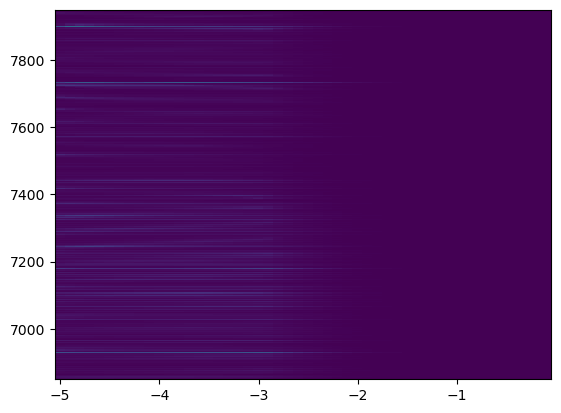

file saved as RK-TWPA_LO_pow_psweep_5.05mA_20240902_2023


In [37]:
plt.pcolor(lopower_array,freqs*1e-6,mags.T)
plt.show()

header_str = get_plot_str(params)
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
np.savez("./data/"+filename,
         header = header_str,
         freqs = freqs,
         lopower_array=lopower_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects  as go 


#Initialize variables for storage
npoints=1000
mags = np.ndarray((len(lopower_array), npoints))
mags_f_pump = np.ndarray((len(qubitFreq_array),npoints))
vna.start_rf()
vna.set_power(params['vna_power'],overule_power=True)

mags[:] = 0
mags_f_pump[:]=0
phases[:] = 0
fig_f_pump=go.Figure(data=go.Heatmap(z=mags_f_pump.T, x=qubitFreq_array, y=freqs*1e-6, colorscale='Viridis', zsmooth='best')) #zmax=25,  zmin=0

lo.open()
lo.stop_rf()
#lo.set_RF(params['qubitFreqInitial'])
#with twpa:   
#clear_output(wait=True)
vna.reset_average()
#delay = max(delays[idx], 0.3)
sleep(5)
mag, phase =  vna.get_data(meas = meas) #freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['f_span'], power = -50, sleep_t = 0.5, npoints = 1001, data_format = 'MA',meas = meas)
mags_pump0 = mag
lo.close()

try:
    for idx, lo_freq in enumerate(qubitFreq_array): 

        #with twpa:
            # #Update center frequecy of the resonator
            # freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=params['span_freq'],power=params['vna_power'], npoints=1001,sleep_t = 5, meas = meas)
            # f_c, Qf, fwhm = Q(freqs,mag, False)
            
            # print('Center frequency: %2.2f Hz'%f_c)
            # print('FWHM: %2.2f kHz'%(fwhm*1e-3))
            # print('Quality Factor: %2.2f'%Qf)

            # freqs, mag, phase = meas_spectrum(vna, 
            #            f_c = f_c, 
            #            f_span= 10e-6, # VNA in unit MHz
            #            power = params['vna_power'],
            #            npoints = 3, 
            #            sleep_t = 3, meas = meas)
            # phase0 = np.mean(phase)
        

        with(lo):
            lo.set_level(-3.5)
            lo.set_RF(lo_freq)
            #with twpa:   
            #sleep(2)
            clear_output(wait=True)
            vna.reset_average()
            #delay = max(delays[idx], 0.3)
            sleep(5)
            mag, phase =  vna.get_data(meas = meas) #freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['f_span'], power = -50, sleep_t = 0.5, npoints = 1001, data_format = 'MA',meas = meas)
            mags_f_pump[idx] = mag#/mags_pump0

        
            # Plot
                #fig = make_subplots(rows=1, cols=2, subplot_titles=("Magnitude","Phase"))
                #fig.add_trace(go.Heatmap(x=lopower_array,y=freqs*1e-6, z=mags.T, colorbar=dict(x=.45,len=1)))
            #fig.add_trace(go.Heatmap(x=lopower_array,y=qubitFreq_array,z=phases, colorbar=dict(x=1,len=1)),row=1,col=2)
                #fig.show()
            fig_f_pump.data[0].z=mags_f_pump.T
            fig_f_pump.show()
            
            #plt.pcolor(lopower_array,qubitFreq_array,mags)
            #plt.show()
    #Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    print('Measurement finished. Stopping the sources.')
    vna.stop_rf()


# filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
# header_str = get_plot_str(params, filename)
# np.savez("./data/"+filename,
#          header = header_str,
#          freqs=qubitFreq_array,
#          axis2 = lopower_array,
#          mags=mags,
#          phases=phases)
# print('file saved as %s'%filename)

Measurement finished. Stopping the sources.


In [46]:
fig_f_pump_=go.Figure(data=go.Heatmap(z=np.transpose(20*np.log10(mags_f_pump.T)),
                                    y=qubitFreq_array,
                                    x=freqs*1e-6,
                                    colorscale='Viridis',
                                    #zmax=30,
                                    zmax=20*np.log10(mags_f_pump.T.max()),
                                    zmin=20*np.log10(mags_f_pump.T.min()),
                                    zsmooth='best'))
fig_f_pump_.update_layout(
    autosize=False,
    width=900,
    height=600)
fig_f_pump_.show()

In [3]:
plt.plot(freqs*1e-6,np.transpose(20*np.log10(mags_f_pump[50])))
plt.plot(freqs*1e-6,np.transpose(20*np.log10(mags_f_pump[149])))
plt.plot(freqs*1e-6,np.transpose(20*np.log10(mags_f_pump[75])))

NameError: name 'plt' is not defined